In [1]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from typing_extensions import TypedDict

openrouter_url = "https://openrouter.ai/api/v1"
openrouter_api_key = "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"


llm = init_chat_model(
    "anthropic/claude-sonnet-4",
    model_provider="openai",
    base_url=openrouter_url,
    api_key=openrouter_api_key,
)


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str


@tool
def human_assistance(name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    return Command(update=state_update)


@tool
def search_web(query: str) -> str:
    """Search the web for information."""
    print(f"Searching the web for {query}")
    return "Web search result"


tools = [search_web, human_assistance]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


### 绘制流程图

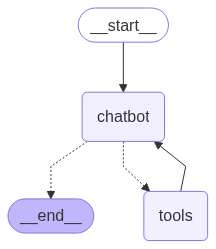

In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [3]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": ("I'm learning LangGraph. " "Could you do some research on it for me?"),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

I'll search for information about LangGraph to help you with your learning!
Tool Calls:
  search_web (toolu_01Cz8SctifdTi4ekLQ2mSyLQ)
 Call ID: toolu_01Cz8SctifdTi4ekLQ2mSyLQ
  Args:
    query: LangGraph tutorial documentation overview
Searching the web for LangGraph tutorial documentation overview
================================= Tool Message =================================
Name: search_web

Web search result
================================== Ai Message ==================================

Let me search for more specific information about LangGraph:
Tool Calls:
  search_web (toolu_01UjvUUQKk32BbaCfptKtRP8)
 Call ID: toolu_01UjvUUQKk32BbaCfptKtRP8
  Args:
    query: what is LangGraph LangChain graph framework
Searching the web for what is LangGraph LangChain

In [4]:
from langchain_core.messages import BaseMessage


In [5]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": ("Ya that's helpful. Maybe I'll " "build an autonomous agent with it!"),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        last_message: BaseMessage = event["messages"][-1]
        last_message.pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That's an excellent idea! LangGraph is particularly well-suited for building autonomous agents. Let me search for some specific information about creating autonomous agents with LangGraph:
Tool Calls:
  search_web (toolu_01TCGrVqXpAi4PijKy1X9Pz4)
 Call ID: toolu_01TCGrVqXpAi4PijKy1X9Pz4
  Args:
    query: LangGraph autonomous agent tutorial examples
Searching the web for LangGraph autonomous agent tutorial examples
================================= Tool Message =================================
Name: search_web

Web search result
================================== Ai Message ==================================
Tool Calls:
  search_web (toolu_0164QVdG3xdqiBoSVVC3cmj3)
 Call ID: toolu_0164QVdG3xdqiBoSVVC3cmj3
  Args:
    query: LangGraph agent with tools ReAct pat

## 重放历史

In [20]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 7:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        print(f"[bold green]Found state to replay:[/bold green] {state.next}")
        to_replay = state

Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
[bold green]Found state to replay:[/bold green] ('chatbot',)
Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
[bold green]Found state to replay:[/bold green] ('chatbot',)
Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
[bold green]Found state to replay:[/bold green] ('chatbot',)
Num Messages:  16 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  15 Next:  ('cha

## 从检查点恢复


In [7]:
# snapshot = graph.get_state(config)
# snapshot.next
# snapshot.values["messages"][-1].pretty_print()

In [21]:
print(to_replay.next)
print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03a3ec-6808-6028-8006-0182e2fe812b'}}


### 加载某个时刻的状态 

In [22]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: search_web

Web search result
================================== Ai Message ==================================

Based on my research, here's what I found about LangGraph:

## What is LangGraph?

LangGraph is a framework developed by LangChain for building **stateful, multi-actor applications** with Large Language Models (LLMs). It's designed to create complex workflows that go beyond simple sequential chains.

## Key Features:

1. **Graph-based Architecture**: Build applications as directed graphs where each node represents a function or process
2. **State Management**: Maintains state across different steps in your workflow
3. **Multi-agent Coordination**: Enables multiple AI agents to work together
4. **Conditional Logic**: Supports branching and conditional execution paths
5. **Human-in-the-loop**: Allows for human intervention at specific points

## Common Use Cases:

- **Multi-agent systems** wh

In [23]:
import rich

rich.inspect(to_replay)

╭──────────────────────────────────── <class 'langgraph.types.StateSnapshot'> ────────────────────────────────────╮
│ Snapshot of the state of the graph at the beginning of a step.                                                  │
│                                                                                                                 │
│ ╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ StateSnapshot(                                                                                              │ │
│ │ │   values={                                                                                                │ │
│ │ │   │   'messages': [                                                                                       │ │
│ │ │   │   │   HumanMessage(                                                                                   │ │
│ │ │   │   │   │   content="I'm learning LangGraph. Could you do some research on it for"+4,                   │ │
│ │ │   │   │   │   additional_kwargs={},                                                                       │ │
│ │ │   │   │   │   response_metadata={},                                                                       │ │
│ │ │   │   │   │   id='6a079f9f-d1e6-4cec-b585-388b6e1098b8'                                                   │ │
│ │ │   │   │   ),                                                                                              │ │
│ │ │   │   │   AIMessage(                                                                                      │ │
│ │ │   │   │   │   content="I'll search for information about LangGraph to help you with"+15,                  │ │
│ │ │   │   │   │   additional_kwargs={                                                                         │ │
│ │ │   │   │   │   │   'tool_calls': [                                                                         │ │
│ │ │   │   │   │   │   │   {                                                                                   │ │
│ │ │   │   │   │   │   │   │   'id': 'toolu_01Cz8SctifdTi4ekLQ2mSyLQ',                                         │ │
│ │ │   │   │   │   │   │   │   'function': {                                                                   │ │
│ │ │   │   │   │   │   │   │   │   'arguments': '{"query": "LangGraph tutorial documentation overview"}',      │ │
│ │ │   │   │   │   │   │   │   │   'name': 'search_web'                                                        │ │
│ │ │   │   │   │   │   │   │   },                                                                              │ │
│ │ │   │   │   │   │   │   │   'type': 'function',                                                             │ │
│ │ │   │   │   │   │   │   │   'index': 0                                                                      │ │
│ │ │   │   │   │   │   │   }                                                                                   │ │
│ │ │   │   │   │   │   ],                                                                                      │ │
│ │ │   │   │   │   │   'refusal': None                                                                         │ │
│ │ │   │   │   │   },                                                                                          │ │
│ │ │   │   │   │   response_metadata={                                                                         │ │
│ │ │   │   │   │   │   'token_usage': {                                                                        │ │
│ │ │   │   │   │   │   │   'completion_tokens': 76,                                                            │ │
│ │ │   │   │   │   │   │   'prompt_tokens': 456,                                                               │ │
│ │ │   │   │   │   │   │   'total_tokens': 532,                                                                │ │
│ │ │   │   │   │   │   │   'completion_tokens_details':